In [1]:
from data_loader import read_json_as_df

import nltk
import scipy
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn import utils
from gensim.models import Doc2Vec
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC, LinearSVC
from gensim.models.doc2vec import TaggedDocument
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

In [2]:
train_df = read_json_as_df('combined-train.json')
test_df = read_json_as_df('combined-test.json')

In [3]:
def create_doc2vec_embeddings(train_df: pd.DataFrame, test_df: pd.DataFrame):

#-----------------------------------------------------------------
    def tokenize(text):
        tokens = []
        for sent in nltk.sent_tokenize(text):
            for word in nltk.word_tokenize(sent):
                if len(word) < 2:
                    continue
                tokens.append(word.lower())
        return tokens
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        labels, vectors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return labels, vectors
    
#-----------------------------------------------------------------

    train_tagged = train_df.apply(
        lambda r: TaggedDocument(words=tokenize(r.text), 
                                 tags=[r.priority]), axis=1)
    test_tagged = test_df.apply(
        lambda r: TaggedDocument(words=tokenize(r.text), 
                                 tags=[r.priority]), axis=1)

    model_dbow = Doc2Vec(cores=12)

    model_dbow.build_vocab([x for x in train_tagged.values])

    for epoch in range(30):
        model_dbow.train(utils.shuffle([x for x in train_tagged.values]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha

    ytrain, xtrain = vec_for_learning(model_dbow, train_tagged)
    ytest, xtest = vec_for_learning(model_dbow, test_tagged)
    
    return xtrain, ytrain, xtest, ytest

In [4]:
xtrain, ytrain, xtest, ytest = create_doc2vec_embeddings(train_df, test_df)

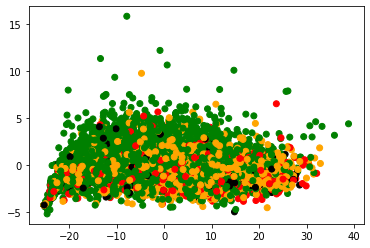

In [5]:
pca = PCA(n_components=2).fit(xtrain)

features_2d = pca.transform(xtrain)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=train_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

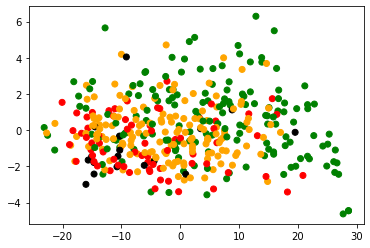

In [6]:
pca = PCA(n_components=2).fit(xtest)

features_2d = pca.transform(xtest)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=test_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

In [ ]:
%%time

params = [
    {'C': [0.1, 1.0, 10], 'gamma': [0.01, 0.1, 1.0], 'kernel': ['rbf'], 'class_weight':['balanced']},
    {'C': [1.0, 10, 100, 1000, 10000], 'kernel': ['linear'], 'class_weight':['balanced']}
]

clf = GridSearchCV(estimator=SVC(),
                         param_grid=params,
                         n_jobs=-1,
                         scoring='f1_macro',
                         cv=5)

svc_searched_clf = clf.fit(xtrain, ytrain)

print('Best Params:', svc_searched_clf.best_params_, '\n')
print('Best macro avg F1 score:', svc_searched_clf.best_score_, '\n')
print(svc_searched_clf.best_estimator_, '\n')

# Main method to fit and test classifier

In [ ]:
def run_tfidf_svc(clf, xtest, ytest):
    
    predicted_priority = clf.predict(xtest)

    print('Classification Report:\n', classification_report(ytest, predicted_priority))
    
    return predicted_priority
    
    

# Train and test on full datasets

In [ ]:
predicted_priority = run_tfidf_svc(clf = svc_searched_clf.best_estimator_,
                                   xtest = xtest,
                                   ytest = ytest)

## Official - ignoring 'green' priority

In [ ]:
print('Macro avgd f1 score: ',
      f1_score(ytest,
               predicted_priority, 
               labels=['escalate', 'red', 'amber'],
               average='macro'))

## Flagged - 'crisis + red + amber' as flagged vs 'green'

In [ ]:
def map_flagged(label):
    if label in ['escalate', 'red', 'amber']:
        return 'flagged'
    elif label == 'green':
        return 'green'

flagged_ytest = list(map(map_flagged, ytest))
flagged_predictions = list(map(map_flagged, predicted_priority))

print('Classification Report:\n', classification_report(flagged_ytest, flagged_predictions))

## Urgent - 'red + escalate' as urgent vs 'amber + green' as non_urgent

In [ ]:
def map_urgent(label):
    if label in ['escalate', 'red']:
        return 'urgent'
    elif label in ['green', 'amber']:
        return 'non-urgent'

urgent_ytest = list(map(map_urgent, ytest))
urgent_predictions = list(map(map_urgent, predicted_priority))

print('Classification Report:\n', classification_report(urgent_ytest, urgent_predictions))